Code to correct the aberration mainly introcuded by the R11 SLM. This work is based on Mark Neil's Matlab code:`startestWFSnew.m`. A Thorlabs scientific camera(CS2100M-USB) is used to obtain PSF images.

In [1]:
import sys
print(sys.path)

['C:\\Users\\ML2618\\PycharmProjects\\HexSimInstrument', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\python38.zip', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\DLLs', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib', '', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages', 'C:\\Users\\ML2618\\PycharmProjects\\napari-pcd-reader_draft\\src', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\win32\\lib', 'C:\\Users\\ML2618\\Anaconda3\\envs\\napari-generic-SIMulator\\lib\\site-packages\\Pythonwin']


In [2]:
import numpy as np
import cupy as cp
from scipy import ndimage, interpolate
import matplotlib.pyplot as plt
from matplotlib import animation
import time
from IPython import display
from pylablib.devices import Thorlabs
import ctypes as ct
from random import randrange
import subprocess, os
import opt_einsum as oe
import nidaqmx
import nidaqmx.system as ni

In [3]:
xp = cp
n_bias = 3

In [4]:
# cam.close()
print(f'Cameras attached: {Thorlabs.list_cameras_tlcam()}')
cam = Thorlabs.ThorlabsTLCamera()

Cameras attached: ['14403']


In [164]:
cam.close()

slm.deactivate()
slm.close()

do_har.disconnect()

Port closed successfully


## SLM's device functions

In [5]:
class Dev(ct.Structure):
    pass
Dev._fields_ = [("id", ct.c_char_p), ("next", ct.POINTER(Dev))]
                
                
class SLMDev():
    """
    Connect to the real-world Methods allow for device read and write functions for R11 SLM.
    """

    def __init__(self):

        self.NULL = ct.POINTER(ct.c_int)()
        self.RS485_DEV_TIMEOUT = ct.c_uint16(1000)
        self.r11 = ct.windll.LoadLibrary('C:/Program Files/MetroCon-4.1/R11CommLib-1.8-x64.dll')
        self.xpix = 2048
        self.ypix = 2048
        self.xv, self.yv = self.interleaving()
        
    def initiate(self):
        ver = ct.create_string_buffer(8)
        maxlen = ct.c_uint8(10)
        res = self.r11.R11_LibGetVersion(ver, maxlen)
        if (res == 0):
            print('Software version: %s' % ver.value)
        else:
            raise Exception('Libarary not loaded')
        guid = ct.c_char_p(b"54ED7AC9-CC23-4165-BE32-79016BAFB950")
        devcount = ct.c_uint16(0)
        devlist = ct.POINTER(Dev)()
        res = self.r11.FDD_DevEnumerateWinUSB(guid, ct.pointer(devlist), ct.byref(devcount))
        if res == 0:
            port = devlist.contents.id.decode()
            print('Dev port: %s' % port)
        else:
            raise Exception('Cannot find the port')

    def open_usb_port(self):
        port = ct.c_char_p(b'\\\\?\\usb#vid_19ec&pid_0503#0175000881#{54ed7ac9-cc23-4165-be32-79016bafb950}')
        re = self.r11.FDD_DevOpenWinUSB(port, self.RS485_DEV_TIMEOUT)
        if re == 0:
            print('Open Dev port successfully')
            dispTemp = ct.c_uint16(0)
            self.r11.R11_RpcSysGetDisplayTemp(ct.byref(dispTemp))
            print('Display temperature: %s' % dispTemp.value)
        else:
            raise Exception(' Fail to open the port ')
    
    def print_tem(self):
        dispTemp = ct.c_uint16(0)
        re = self.r11.R11_RpcSysGetDisplayTemp(ct.byref(dispTemp))
        if re == 0:
            dispTemp = dispTemp >> 4
            if dispTemp < 2048:
            # Positive temperature
                dispTemp = float(dispTemp) / 16.0
            else:
                # Negative temperature
                dispTemp = -np.float64(4096 - dispTemp) / 16.0

            print(f'Display temperature: {(dispTemp.value >> 8) & 0xff}.{ct.c_int8(dispTemp.value).value}')
            print(dispTemp.value)
        else:
            raise Exception

    def activate(self,):
        res = self.r11.R11_RpcRoActivate(ct.c_void_p())
        if res != 0:
            raise Exception(f'Fail to activate SLM. Error code: {res}')

    def deactivate(self):
        res = self.r11.R11_RpcRoDeactivate(ct.c_void_p())
        if res != 0:
            raise Exception(f'Fail to deactivate. Error code: {res}')

    def getordernum(self):
        rocount = ct.c_uint16(0)
        res = self.r11.R11_RpcRoGetCount(ct.byref(rocount))
        if res == 0:
            num = rocount.value
            print('order number: %s' % num)
        else:
            raise Exception('Fail to get the order number')

    def getActivationType(self):
        """Retrieve the activation typr of the currently loaded running order"""
        actType = ct.c_uint8(0)
        res = self.r11.R11_RpcRoGetActivationType(ct.byref(actType))
        if res == 0:
            return actType.value
        else:
            raise Exception('Failed to get activation type')

    def getRO(self):
        roindex = ct.c_uint16(0)
        res_index = self.r11.R11_RpcRoGetSelected(ct.byref(roindex))
        roName = ct.create_string_buffer(255)
        res_name = self.r11.R11_RpcRoGetName(roindex, roName, len(roName))
        if (res_index == 0) & (res_name == 0):
            return roindex.value, roName.value
        elif res_index != 0:
            raise Exception('Failed to get RO index')
        elif res_name != 0:
            raise Exception('Failed to get RO name')

    def getRepName(self):
        """Retrieve the name of the repertoire loaded on the board."""
        repName = ct.create_string_buffer(255)
        re = self.r11.R11_RpcSysGetRepertoireName(repName, len(repName))
        if re == 0:
            return repName.value
        else:
            raise Exception('Failed to get repertoire name')

    def setRO(self, n):
        roindex = ct.c_uint16(n)
        res = self.r11.R11_RpcRoSetSelected(roindex)
        if res == 0:
            num = roindex.value
            print(f'Order is set to {num}')
        else:
            raise Exception('Failed to set the order')

    def getState(self):
        actState = ct.c_uint8(0)
        self.r11.R11_RpcRoGetActivationState(ct.byref(actState))
        return actState.value

    def close(self):
        res = self.r11.FDD_DevClose()
        if res == 0:
            print('Port closed successfully')
        else:
            raise Exception('Fail to closE R11 SLM')

    def interleaving(self):
        x0 = xp.zeros(self.xpix)
        y0 = xp.arange(self.ypix)

        nr = xp.arange(8)
        for i in range(64):
            x0[(i * 32):(i * 32 + 8)] = nr + i * 8
            x0[(i * 32 + 8):(i * 32 + 16)] = nr + i * 8 + 512
            x0[(i * 32 + 16):(i * 32 + 24)] = nr + i * 8 + 1024
            x0[(i * 32 + 24):(i * 32 + 32)] = nr + i * 8 + 1536
        # x0 is now an array of interleaved x values in the correct places for sending to the SLM

        x, y = xp.meshgrid(x0, y0)
        return x, y

    def sendBitplane(self, data, frameno):
        print(f'sending frame number {frameno}')
        t0 = time.time()
        for block in range(4):
            block_address = 0x01000000 + block * 64 + frameno * 256
            # Flash blocks per bitplane: 4
            # Flash pages per bitplane: 256
            res = self.r11.R11_RpcFlashEraseBlock(ct.c_uint32(block_address))
            if res != 0:
                raise Exception(f'Fail to erase block {block}')
            for page in range(64):
                buf = np.uint8(data[(block * 64 + page) * 2048:(block * 64 + page) * 2048 + 2048])
                res = self.r11.R11_FlashWrite(buf.ctypes.data_as(ct.POINTER(ct.c_uint8)), ct.c_uint16(0),
                                              ct.c_uint16(2048))
                if res != 0:
                    raise Exception(f'Fail write block {block}: page {page}')
                page_address = ct.c_uint32(block_address + page)
                res = self.r11.R11_FlashBurn(page_address)
                if res != 0:
                    raise Exception(f'Fail burn block {block}: page {page}')
        print(f'bitplane sent in {time.time() - t0}')

    def eraseBitplane(self, frameno):
        for block in range(4):
            block_address = 0x01000000 + block * 64 + frameno * 256

            res = self.r11.R11_RpcFlashEraseBlock(ct.c_uint32(block_address))
        if res == 0:
            print(f'Frame number {frameno} erased')
        else:
            raise Exception(f'Fail to erase block {block}')

    def repReload(self):
        res = self.r11.R11_RpcSysReloadRepertoire()
        t0 = time.time()
        while self.getProgress() != 100:
            self.getProgress()
        t = time.time() - t0
        print(f'Elapsed time of reloading: {t}')
        if res != 0:
            raise Exception('Fail reload repertoire')

    def getProgress(self):
        """Get the progress of the current board operation."""
        p = ct.c_uint8(0)
        res = self.r11.R11_DevGetProgress(ct.byref(p))
        if res != 0:
            raise Exception(f'Fail to get progress. Error code: {res}')
        return p.value

## SLM's hardware functions

In [6]:
class SLMHar():
    """class to control the SLM hardware"""
    BPins = [None] * n_bias

    def flashCorrection(self, bp_img):
        randImg = randrange(11, 768 - n_bias)
        for i in range(len(bp_img)):
            self.BPins[i] = randImg + i  # bit planes index
        for k in range(len(bp_img)):
            slm.sendBitplane(bp_img[k], self.BPins[k])

            
    def writeCorrRep(self, fns, mode, imgns='hol.png'):
        """write a text file of the SLM correction repertoire and save it as '.rep' format,and then build it to a '.repz11' file."""
        os.chdir('C:/Users/ML2618/Desktop/SLMtests')
        with open(f'{fns}.txt', 'w') as f:
            data = ("ID\n"
                    '"V1.0 ${date(\\"yyyy-MMM-dd HH:mm:ss\\")}"\n'
                    "ID_END\n\n"
                    "PLATFORM\n"
                    '"R11"\n'
                    "PLATFORM_END\n\n"
                    "DISPLAY\n"
                    '"2Kx2K"\n'
                    "DISPLAY_END\n\n"
                    "FORMATVERSION\n"
                    '"FV4"\n'
                    "FORMATVERSION_END\n\n"
                    "SEQUENCES\n")
            f.write(data)

            data2 = ('A "48163 10ms 1-bit Balanced.seq11"\n'
                     'SEQUENCES_END\n\n'
                     'IMAGES\n')
            f.write(data2)

            for i in range(3):
                data3 =(f' 1 "{imgns}"\n')
                f.write(data3)

            data4 = ('IMAGES_END\n'
                     f'DEFAULT "R01"\n'
                    '[HWA \n')
            f.write(data4)
                
            if mode == 'nh':  # no hardware triggering
                data5 = (f'< (A,{self.BPins[0]}) (A,{self.BPins[1]}) (A,{self.BPins[2]}) >\n'
                         ']\n')
            else:
                data5 = (f'< t(A,{self.BPins[0]}) (A,{self.BPins[1]}) (A,{self.BPins[2]}) >\n'
                         ']\n')
            f.write(data5)

        os.rename(f'{fns}.txt', f'{fns}.rep')
        print('New rep file created')

        # build the rep to a repz11 file
        print(os.getcwd())
        output = subprocess.run(['RepBuild', fns + '.rep', '-c', fns + '.repz11'], shell=True,
                                stdout=subprocess.PIPE)
        if output.returncode == 0:
            print(output.stdout.decode())
            print('repz11 file created')
        else:
            print(f'rep to repz11 failed, error: {output.stderr}')

    def repSendBP(self, fn):
        """Send the repz.11 file to the board. fn: file name, e.g. 'test1'"""
        slm.close()
        output = subprocess.run(['RepSender', '-z', fn, '-d', '0175000881', '-i'], shell=True, stdout=subprocess.PIPE)
        if output.returncode == 0:
            print('New repertoire sent without images.')
        else:
            print(f'Repertoire sending without images failed, error: {output.stderr}')
        slm.open_usb_port()
        
    def updateBp(self, imgs, fn, mode):
        t0 = time.time()
        self.flashCorrection(imgs)
        self.writeCorrRep(fn, mode)
        self.repSendBP(fn +'.repz11')
        print(f'Repertoire updated in {time.time() - t0}s')

## NI's CO functions

In [7]:
# class NI_CO():

#     def __init__(self):
#         self.dict = {"rising": nidaqmx.constants.Edge.RISING,
#                      "falling": nidaqmx.constants.Edge.FALLING}
        
#     def connect(self):
#         board, self.terminals, self.trig = self.update_channels()

#     def start_task(self, c, d, h, l, ist, ts, te='rising'):
#         self.task_ni = nidaqmx.Task()
#         self.task_ni.co_channels.add_co_pulse_chan_time(counter=c,
#                                                         initial_delay=d,
#                                                         high_time=h, low_time=l)
# #         self.task_ni.co_channels.add_co_pulse_chan_time(counter=self.channel2, high_time=self.high_time2,
# #                                                         initial_delay=self.initial_delay_chan2,
# #                                                         low_time=self.period2 - self.high_time2)
#         # self.task.co_channels.add_co_pulse_chan_time(counter=self.channel, units=nidaqmx.constants.TimeUnits.SECONDS,
#         # idle_state=nidaqmx.constants.Level.LOW, initial_delay=0, low_time=0.01, high_time=0.01)
#         self.task_ni.timing.cfg_implicit_timing(sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,
#                                                 samps_per_chan=100)
#         # samps_per_chan(*or/)freq must be an integer! (maybe)
#         if ist:
#             self.task_ni.triggers.start_trigger.trig_type = nidaqmx.constants.TriggerType.DIGITAL_EDGE
#             self.task_ni.triggers.start_trigger.cfg_dig_edge_start_trig(trigger_source=ts,
#                                                                         trigger_edge=self.dict.get(te))
#         self.task_ni.start()
        
#     def stop_task(self):
#         # suppress warning that might occur when task i stopped during acquisition
#         # warnings.filterwarnings('ignore', category=nidaqmx.DaqWarning)
#         self.task_ni.stop()  # stop the task(different from the closing of the task, I suppose)
#         # warnings.filterwarnings('default',category=nidaqmx.DaqWarning)
#         self.task_ni.close()

        
#     def update_channels(self):
#         ''' Find a NI device and return board + do_terminals + trigger terminals'''
#         system = ni.System.local()
#         device = system.devices[0]
#         board = device.product_type + ' : ' + device.name
#         terminals = []
#         trig = []
#         for line in device.co_physical_chans:
#             terminals.append(line.name)
#         for j in device.terminals:
#             if 'PFI' in j:
#                 trig.append(j)

#         return board, terminals, trig

In [8]:
class NI_DO_device():
    
    def __init__(self, channel):
        self.channel = channel
                 
        self.Task()
    
    def Task(self):
        if hasattr(self, 'task'):
            self.close()
            
        self.task = nidaqmx.Task()
        self.task.do_channels.add_do_chan(lines=self.channel)
        
    def write(self, value):
        self.task.write(bool(value))
            
    def close(self):
        self.task.stop()
        self.task.close() #close the task

## NI's hardware functions

In [9]:
class NI_DO_hw():
    
    name = 'NI_DO_hw' 
    
    def setup(self):
        #create logged quantities, that are related to the graphical interface
        board, terminals=self.update_channels()
        print(terminals)
      
    def connect(self):     
        #open connection to hardware
        self.DO_device = NI_DO_device(channel='Dev1/port1/line0')
        
    def disconnect(self):
        #disconnect hardware
        if hasattr(self, 'DO_device'):
            self.DO_device.close()
            del self.DO_device
            
    def write_value(self, v):
        self.DO_device.write(v)
        print(f'write {v}')
        
    def update_channels(self):
        ''' Find a NI device and return board + do_terminals'''
        system = ni.System.local()
        device=system.devices[0]
        board=device.product_type + ' : ' + device.name
        terminals=[]
        for line in device.do_lines :
            terminals.append(line.name)
        return board, terminals

In [10]:
# slm.deactivate()
# slm.close()

In [11]:
slm = SLMDev()
slm.initiate()
slm.open_usb_port()
slm.activate()

Software version: b'1.8.189.'
Dev port: \\?\usb#vid_19ec&pid_0503#0175000881#{54ed7ac9-cc23-4165-be32-79016bafb950}:0175000881
Open Dev port successfully
Display temperature: 9936


In [12]:
slm.print_tem()

Display temperature: 38.-64
9920


In [13]:
har = SLMHar()

In [14]:
do_har = NI_DO_hw()
do_har.setup()
do_har.connect()

['Dev1/port0/line0', 'Dev1/port0/line1', 'Dev1/port0/line2', 'Dev1/port0/line3', 'Dev1/port0/line4', 'Dev1/port0/line5', 'Dev1/port0/line6', 'Dev1/port0/line7', 'Dev1/port1/line0', 'Dev1/port1/line1', 'Dev1/port1/line2', 'Dev1/port1/line3', 'Dev1/port1/line4', 'Dev1/port1/line5', 'Dev1/port1/line6', 'Dev1/port1/line7', 'Dev1/port2/line0', 'Dev1/port2/line1', 'Dev1/port2/line2', 'Dev1/port2/line3', 'Dev1/port2/line4', 'Dev1/port2/line5', 'Dev1/port2/line6', 'Dev1/port2/line7']


In [48]:
# co_har = NI_CO()
# co_har.connect()

In [94]:
# co_har.start_task(co_har.terminals[0], 0, 0.010, 0.010, True, co_har.trig[0])

# Aberration correction

In [15]:
# Scaling calculation all distances in µm

# camera pixel size
d_c = 5.04
# camera roi size
N = 256

# slm pixel size
d_s = 8.2
# slm roi size
n_s = 2048

# fourier focal length
f = 300e3
# wavelength
l = 0.52

In [16]:
# Sampling in pupil plane
s_p = f * l / (N * d_c)
print(f's_p = {s_p:.3f}')

# pupil plane diameter in pixels
d_p = n_s * d_s / s_p
print(f'd_p = {d_p:.3f}')

s_p = 120.908
d_p = 138.896


In [17]:
# Scaling from pupil plane to SLM plane
s_fac = n_s / d_p
print(f's_fac = {s_fac:.3f}') 

s_fac = 14.745


Set up arrays and Chebyshev polynomials

In [18]:
xx = xp.linspace(-N / d_p, N / d_p, N)
m = np.abs(xx) < 1
ne = (N - sum(m)) // 2  # 1/2 number of elements along side of pupil
xx *= m

# weight function along 1-d
wtx = (1 / xp.sqrt(1 - (xx ** 2))) * m
# find correctiom to end element that makes intergral(Ch[0]*Ch[2]*wtx) = 0
s = xp.sum(wtx * (2 * xx ** 2 - 1) )
df = s / (2 * xx[ne] ** 2 - 1) / 2
wtx[ne] -= df
wtx[-ne - 1] = wtx[ne]

# Now calculate 2-d weights
x, y = xp.meshgrid(xx, xx)
circ = xp.outer(m, m)
wt = xp.outer(wtx, wtx)
r = xp.sqrt(x ** 2 + y ** 2)

# weight the target PSF towards the centre (or not if all ones)
G = xp.ones((int(N), int(N)))

n_c = 6
n_p = 4

def set_C(xc, yc, n_c, Nc, circ0):
    ch = np.zeros((n_c, n_c, Nc, Nc))
    if xp == cp:
        xc = xc.get()
        yc = yc.get()
        for n in range(n_c):
            for k in range(n_c):
                c = np.zeros((n + 1, k + 1))
                c[n, k] = 1
                ch[n, k, :, :] = np.polynomial.chebyshev.chebval2d(xc, yc, c) * circ0.get()
        ch = cp.array(ch)
    else:
        for n in range(n_c):
            for k in range(n_c):
                c = np.zeros((n + 1, k + 1))
                c[n, k] = 1
                ch[n, k, :, :] = np.polynomial.chebyshev.chebval2d(xc, yc, c) * circ0
    return ch
        
chs = set_C(x, y, n_c, N, circ)
        
c_a_p = xp.reshape(chs, (n_c ** 2, N, N)) # Chebyshev aberration for phase
n_c_i = 4
c_a_i = xp.reshape(chs[:n_c_i, :n_c_i, :, :], (n_c_i ** 2, N, N))  # Chebyshev aberration for intensity   
normval_p = 1 / oe.contract('ijk, ijk, jk -> i', c_a_p, c_a_p, wt)
normval_i = 1 / oe.contract('ijk, ijk, jk -> i', c_a_i, c_a_i, wt)

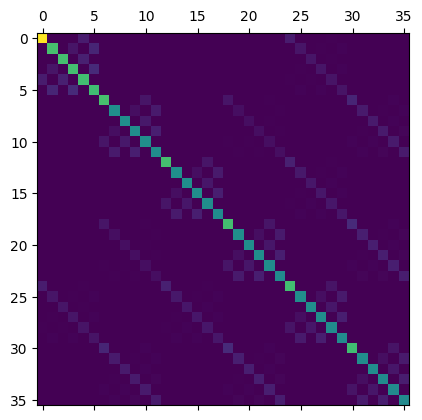

In [19]:
# Orthononality matrix diagonal gives normalisation
plt.matshow(np.abs(oe.contract('ijk, mjk, jk -> im', c_a_p, c_a_p, wt).get()) ** 0.5)

## Chebyshev expansion by orthogonality at nodal points

In [20]:
p_s = np.polynomial.chebyshev.chebpts1(n_c + 1)
if xp == cp:
    ch_xs, ch_ys = xp.meshgrid(cp.array(p_s), cp.array(p_s))
else:
    ch_xs, ch_ys = xp.meshgrid(p_s, p_s)

In [21]:
def set_Cs(xc, yc, n_s):
    if xp == cp:
        xc = xc.get()
        yc = yc.get()
    ch = np.zeros((n_s, n_s, n_s + 1, n_s + 1))
    for n in range(n_s):
        for k in range(n_s):
            c = np.zeros((n + 1, k + 1))
            c[n, k] = 1
            ch[n, k, :, :] = np.polynomial.chebyshev.chebval2d(xc, yc, c)
    if xp == cp:
        ch = cp.array(ch)
    return ch
        
chs_s = set_Cs(ch_xs, ch_ys, n_c)
        
c_a_ps = xp.reshape(chs_s, (n_c ** 2, n_c + 1, n_c + 1)) # Chebyshev aberration for phase
c_a_is = xp.reshape(chs_s[:n_p, :n_p, :, :], (n_p ** 2, n_c + 1, n_c + 1))  # Chebyshev aberration for intensity   
normval_ps = 1 / oe.contract('ijk, ijk -> i', c_a_ps, c_a_ps)
normval_is = 1 / oe.contract('ijk, ijk -> i', c_a_is, c_a_is)
nm = int(xp.sum(m).item())

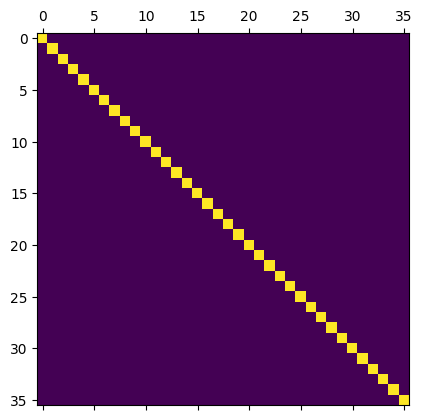

In [22]:
# Orthononality matrix diagonal gives normalisation
plt.matshow((xp.sqrt(xp.abs(oe.contract('ijk, mjk, i -> im', c_a_ps, c_a_ps, normval_ps)))).get())
# with np.printoptions(precision=3, suppress=True):
#     print(oe.contract('ijk, mjk, i -> im', c_a_ps, c_a_ps, normval_ps))

<Figure size 640x480 with 0 Axes>

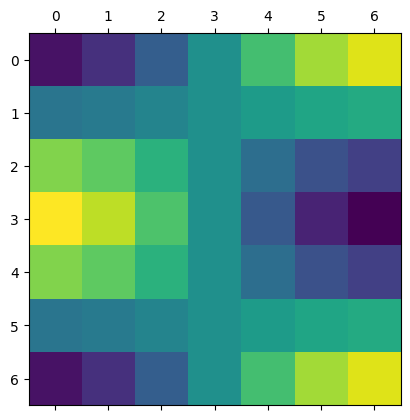

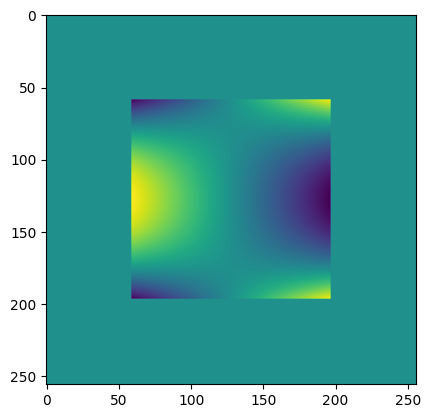

In [23]:
xi = xp.zeros((n_c + 1, n_c + 1, 2))
xi[:, :, 0] = ch_ys
xi[:, :, 1] = ch_xs
c_interp = np.zeros_like(c_a_ps.get())
if xp == cp:
    for i in range(n_c * n_c):
        c_interp[i, :, :] = interpolate.interpn((xx[m].get(), xx[m].get()), 
                                                   c_a_p.get()[i, circ.get()].reshape((nm, nm)), 
                                                   xi.get(), method='splinef2d')
    c_interp = cp.array(c_interp)
else:
    for i in range(n_c * n_c):
        c_interp[i, :, :] = interpolate.interpn((xx[m], xx[m]), 
                                                       c_a_p[i, circ].reshape((nm, nm)), 
                                                       xi, method='splinef2d')
plt.figure()
if xp == cp:
    plt.matshow(c_interp[8].get())
else:
    plt.matshow(c_interp[8].get())
plt.figure()
if xp == cp:
    plt.imshow(c_a_p[8].get())
else:
    plt.imshow(c_a_p[8])

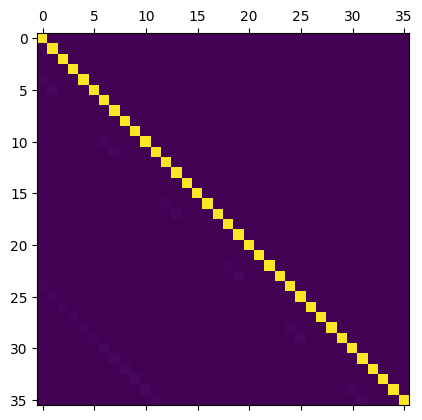

In [24]:
# Orthononality matrix for interpolated data diagonal gives normalisation
plt.matshow((xp.abs(oe.contract('ijk, mjk, i -> im', c_interp, c_a_ps, normval_ps)) ** 0.25).get())

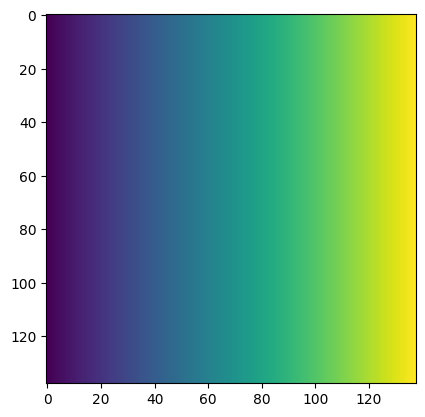

In [25]:
plt.imshow((c_a_p[6,circ].reshape((nm, nm))).get())

## SLM's aberration

<div class="alert alert-block alert-success">
<b> PSFs with the aberration are captured by the camera here.</b>
</div>


### Initial input

In [26]:
beams = 1
if xp == cp:
    # place the pixels in negative and positive axes
    xSLM = (xp.array(slm.xv) - slm.xpix / 2) / (slm.xpix)
    ySLM = (xp.array(slm.yv) - slm.ypix / 2) / (slm.ypix)
else:
    # place the pixels in negative and positive axes
    xSLM = (slm.xv - slm.xpix / 2) / (slm.xpix)
    ySLM = (slm.yv - slm.ypix / 2) / (slm.ypix)
    
Phi = xp.random.random((n_bias, slm.ypix, slm.xpix)) * 2 * np.pi
Tau = xp.zeros((beams, slm.ypix, slm.xpix), dtype=xp.double)  # phase tilt
Psi = xp.zeros((n_bias, slm.ypix, slm.xpix), dtype=xp.double)
F = xp.zeros(beams, dtype=xp.complex_)
G = xp.zeros((slm.ypix, slm.xpix, beams), dtype=xp.complex_)
img = [None] * n_bias

Calculte Chebyshev polynomials for 2048 * 2048 pixels

In [27]:
ND = 2048
xd = xp.linspace(-1, 1, ND)
xD = xd[xp.array(slm.yv, dtype=int)]
yD = -xd[xp.array(slm.xv, dtype=int)]

mD = np.abs(xd) < 1
circD = xp.outer(mD, mD)

chsD = set_C(xD, yD, n_c, ND, circD)
c_a_pD = xp.reshape(chsD, (n_c ** 2, ND, ND)) # Chebyshev aberration for phase

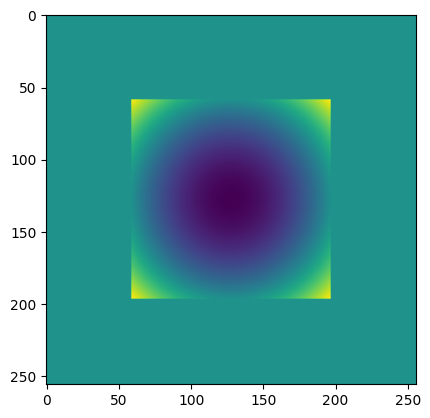

In [28]:
plt.figure(102)
# defocus = 5 * chs[2, 2]
# bias = [5 * chs[2, 2], 0 * (chs[0, 2] + chs[2, 0]), -5 * chs[2, 2]]
# biasD = [5 * chsD[2, 2], 0 * (chsD[0, 2] + chsD[2, 0]), -5 * chsD[2, 2]]

defocus = 4 * (chs[0, 2] + chs[2, 0])
bias = [4 * (chs[0, 2] + chs[2, 0]), 8 * chs[2, 2], -4 * (chs[0, 2] + chs[2, 0])]
biasD = [4 * (chsD[0, 2] + chsD[2, 0]), 8 * chsD[2, 2], -4 * (chsD[0, 2] + chsD[2, 0])]


# biasD = [40 * chsD[0, 1], 0 * chsD[1, 1], 40 * chsD[1, 0]]  # simple tilts for testing holograms on SLM

if xp == cp:
    plt.imshow(defocus.get())
else:
    plt.imshow(defocus)

Generate three initial holograms.

In [29]:
mm = 0.001
wavelength = 520e-9
f = 300 * mm
D = 1.9 * mm  # half the distance between the two corrected orders
p = 1 / (D / wavelength / f) / (0.0082 * mm) / 1.3
hex_bits = [None] * n_bias
hex_bits0 = [None] * n_bias
hex_bitsb = [None] * n_bias

In [30]:
for i in range(beams):
    xpSLM = slm.xpix / p * 2 * np.pi * cp.cos(2 * i * np.pi / 3 + np.pi / 2)
    ypSLM = slm.ypix / p * 2 * np.pi * cp.sin(2 * i * np.pi / 3 + np.pi / 2)
    Tau[i, :, :] = xSLM * xpSLM + ySLM * ypSLM
    
Psi0 = 0
for b in range(n_bias):
    Psi[b] = Psi0 + biasD[b]

G = xp.exp(1j * (Tau + Psi))  # calculate the terms needed for summation
Phi = np.pi * (xp.real(G) < 0) * circD

for k in range(n_bias):
    if xp == cp:
        img[k] = Phi[k].get()
    else:
        img[k] = Phi[k]
    hex_bits0[k] = np.packbits(img[k].astype('int'), bitorder='little')

In [155]:
har.updateBp(hex_bits0, f'test_{time.strftime("%d%m%y_%H%M%S", time.localtime())}', 'h')

sending frame number 294
bitplane sent in 1.230703353881836
sending frame number 295
bitplane sent in 1.2696447372436523
sending frame number 296
bitplane sent in 1.2637228965759277
New rep file created
C:\Users\ML2618\Desktop\SLMtests

REP file: C:\Users\ML2618\Desktop\SLMtests\test_250723_174446.rep
Seq path: C:\Users\ML2618\Desktop\SLMtests
Img path: C:\Users\ML2618\Desktop\SLMtests

Seq file: 48163 10ms 1-bit Balanced.seq11
Img file: hol.png
Img file: hol.png
Img file: hol.png

Target platform: R11 (obtained from Repertoire)
Target display: 2Kx2K (obtained from Repertoire)
Target format version: FV4 (obtained from Repertoire)
Unique identifier (template): "V1.0 ${date(\"yyyy-MMM-dd HH:mm:ss\")}"
Unique identifier (evaluated): V1.0 2023-Jul-25 17:44:51

Creating "test_250723_174446.repz11"

repz11 file created
Port closed successfully
New repertoire sent without images.
Open Dev port successfully
Display temperature: 10240
Repertoire updated in 17.16076111793518s


In [156]:
psfm = [None] * n_bias   # measured psf 
psfi = [None] * n_bias  # psf intensity

# negative: 500, lr
# positive:1500, ud
cam.set_roi(hstart=500-N/2, hend=500+N/2, vstart=600-N/2, vend=600+N/2, hbin=1, vbin=1)
cam.setup_ext_trigger('rise')
# cam.set_trigger_mode('bulb')
cam.set_trigger_mode('ext')
cam.set_exposure(0.001)

cam.setup_acquisition(nframes=n_bias)
cam.open()

Capture three initial PSFs.

In [157]:
cam.start_acquisition()
try:
    do_har.write_value(1)
    while cam.get_frames_status()[1] < 3:
        pass
    cam.stop_acquisition()

    psfm = cam.read_multiple_images()
    cam.clear_acquisition()

    initial_psf = psfm[1]

    for i in range(n_bias):
        psfm[i] = np.fliplr(psfm[i])
        bgz = np.percentile(psfm[i].flatten(), 50)
        bg = np.percentile(psfm[i].flatten(), 95)
        print(f'bg zero: {bgz}. bg filter: {bg}')
        psfm[i] = (psfm[i] - bgz) * (psfm[i] > bg)
        psfm[i] = cp.array(psfm[i])
        psfi[i] = psfm[i] + 0j

    do_har.write_value(0)
except:
    cam.stop_acquisition()
    do_har.write_value(0)

write 1
bg zero: 443.0. bg filter: 582.25
bg zero: 443.0. bg filter: 1430.0
bg zero: 442.0. bg filter: 566.25
write 0


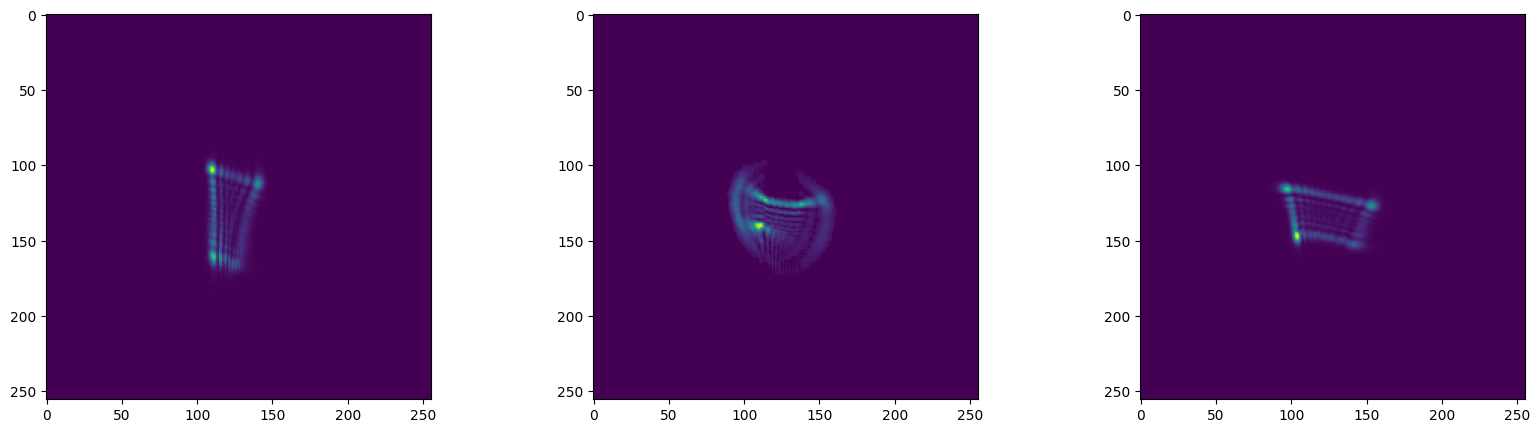

In [158]:
plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    if xp == cp:
        plt.imshow((psfm[i]).get())
    else:
        plt.imshow(psfm[i])

In [159]:
# for the starting test aberration
ri2 = (-18 * chs[1, 1] + 5 * chs[2, 2] 
       - 7 * chs[3, 1] + 11 * chs[3, 3]) * circ / 4  # starting random input phase

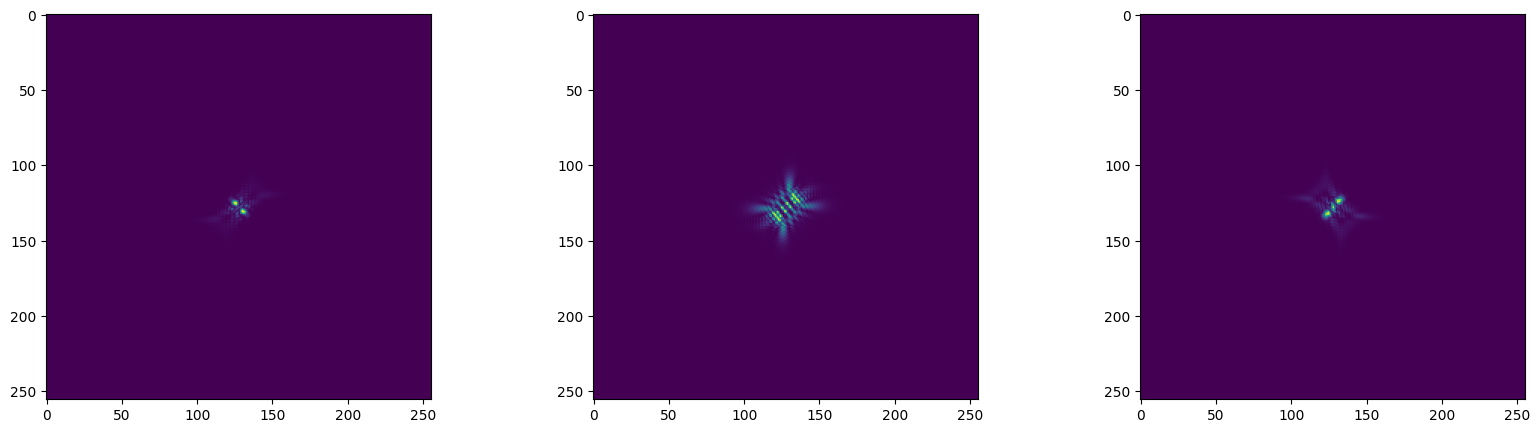

In [160]:
qq = [None] * n_bias
Q = circ * xp.exp(1j * ri2)
for ii in range(n_bias):
    qq[ii] = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[ii])))

plt.figure(figsize=(20, 5))
for i in range(n_bias):
    plt.subplot(1, n_bias, i + 1)
    if xp == cp:
        plt.imshow((xp.abs(qq[i]) ** 2).get())
    else:
        plt.imshow(xp.abs(qq[i]) ** 2)

Work out measured PSFs for the 3 applied masks

## Iteration loop to correct aberrations

In [161]:
ab = xp.zeros((N, N))
qq = [None] * n_bias
QQ = [None] * n_bias

In [162]:
cuml_phase = xp.zeros((N, N))
Q = circ * xp.exp(1j * ri2)
abbD = xp.zeros((ND, ND))
cuml_c = xp.zeros(len(c_a_p))  # accumulated Chebyshev polynonials indices
let = 0  # last elapsed time
rms_plot = []

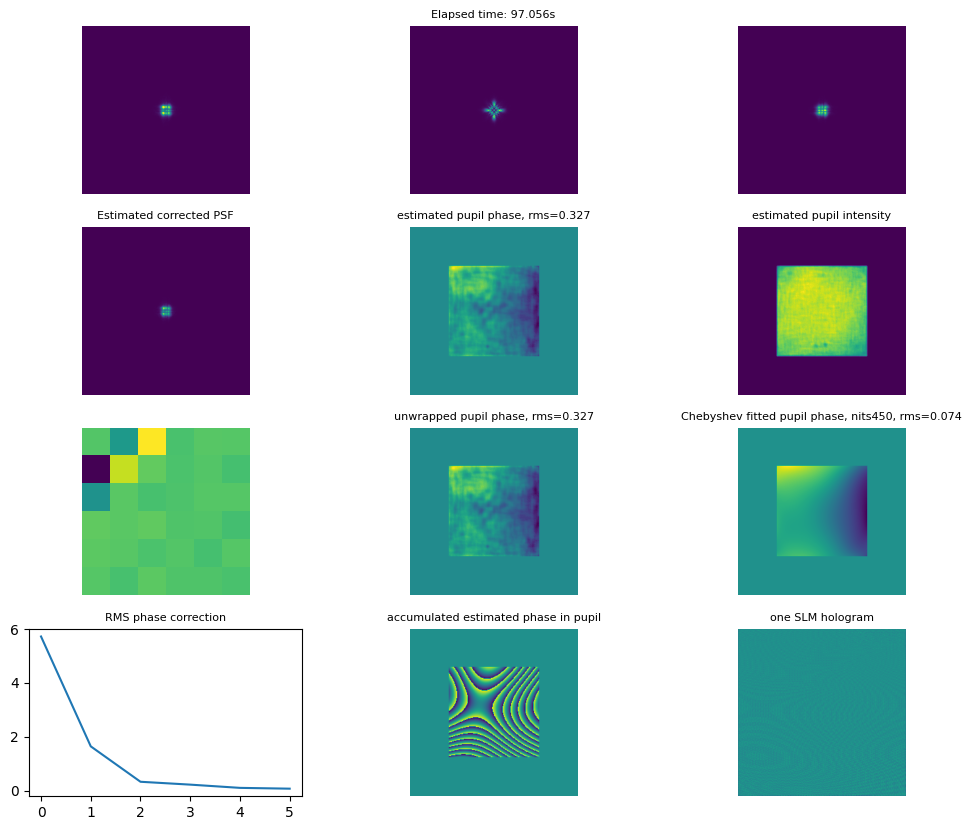

sending frame number 521
bitplane sent in 1.2619826793670654
sending frame number 522
bitplane sent in 1.2516512870788574
sending frame number 523
bitplane sent in 1.2376208305358887
New rep file created
C:\Users\ML2618\Desktop\SLMtests

REP file: C:\Users\ML2618\Desktop\SLMtests\iter450_250723_174644.rep
Seq path: C:\Users\ML2618\Desktop\SLMtests
Img path: C:\Users\ML2618\Desktop\SLMtests

Seq file: 48163 10ms 1-bit Balanced.seq11
Img file: hol.png
Img file: hol.png
Img file: hol.png

Target platform: R11 (obtained from Repertoire)
Target display: 2Kx2K (obtained from Repertoire)
Target format version: FV4 (obtained from Repertoire)
Unique identifier (template): "V1.0 ${date(\"yyyy-MMM-dd HH:mm:ss\")}"
Unique identifier (evaluated): V1.0 2023-Jul-25 17:46:49

Creating "iter450_250723_174644.repz11"

repz11 file created
Port closed successfully
New repertoire sent without images.
Open Dev port successfully
Display temperature: 10224
Repertoire updated in 17.18109655380249s
write 1
writ

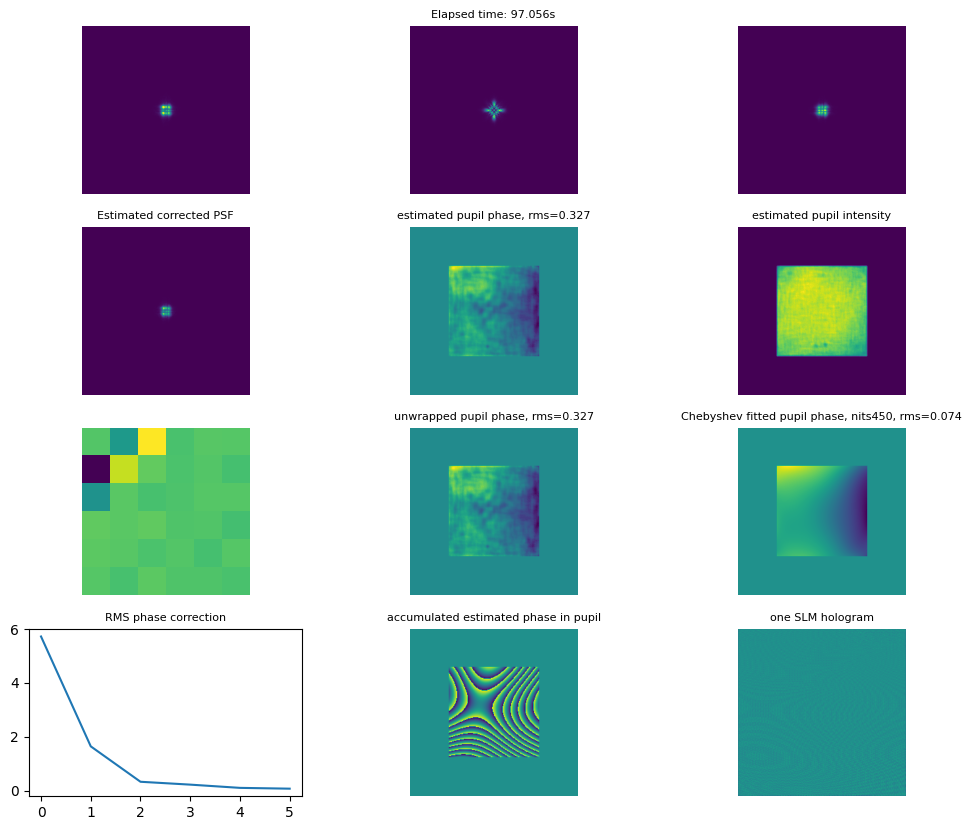

In [163]:
# method = 'weighted'  # two methods for chebyshev orthogonality, "weighted' or 'sampled'
method = 'weighted'

show_ani = True
fsize = 8

if show_ani:
#     f = plt.figure(figsize=(20,20))
    f = plt.figure(figsize=(12,10))
    axes = []
    for i in range(12):
        axes.append(f.add_subplot(4,3,i+1))

def show_animation(k, img, title=None):
    if show_ani:
        axes[k].clear()
        if xp == cp:
            s = axes[k].imshow(img.get())
        else:
            s = axes[k].imshow(img)
        axes[k].set_axis_off()
        if not title is None:
#             axes[k].set_title(title)
            axes[k].set_title(title, fontsize=fsize)
        if k == (11):
            display.clear_output(wait=True)
            display.display(axes[k].get_figure())

nits = 1
n = 75
do_int = False
last_rms = 10.0


t0 = time.time()

while nits < n * 10 + 1:
    for ii in range(n_bias):
        qq[ii] = xp.fft.fftshift(xp.fft.fft2(Q * xp.exp(1j * bias[ii])))
    
    if xp.mod(nits, n) == 0:
        show_animation(0, psfm[0])
        show_animation(1, psfm[1], f'Elapsed time: {let:.3f}s')
        show_animation(2, psfm[2])
        show_animation(3, xp.abs(qq[0]) ** 2, 'Estimated corrected PSF')
        
    Q = 0
    for i in range(n_bias):
        QQ[i] = xp.fft.ifft2(xp.fft.fftshift(xp.sqrt(psfi[i]) * xp.exp(1j * xp.angle(qq[i])))) 
        QQ[i] = QQ[i] * circ * xp.exp(-1j * bias[i])
        Q = Q + QQ[i]

    Qc = xp.angle(Q) * circ

    if xp.mod(nits, n) == 0:
        rms = xp.std(Qc[circ])
        show_animation(4, Qc, f'estimated pupil phase, rms={rms:.3f}')
        show_animation(5, abs(Q), 'estimated pupil intensity')

#         if show_ani:
#             axes[6].clear()
#             if xp == cp:
#                 axes[6].plot(xp.squeeze(abs(Q.get()[N//2,:])))
#             else:
#                 axes[6].plot(xp.squeeze(abs(Q[N//2,:])))

    # Constrain intensity in pupil to have slowly varying values by fitting to Zernike polynomials, up to radial order
    # 4 to help with gaussian illumination
    if do_int:
        c_i = oe.contract('ijk, jk, jk, i -> i', c_a_i, xp.abs(Q), wt, normval_i) 
        Qb = oe.contract('ijk, i -> jk', c_a_i, c_i)
    else:  # Set the amplitude to a uniform pupil if the phase is still changing a lot
        if last_rms < 2 * np.pi:
            do_int = True
        Qb = circ

    Q = Qb * xp.exp(1j * Qc)

    if xp.mod(nits, n) == 0:
        # Smooth the phase and grab new psfs after applying the partial correction

        # Unwrap the phase
        Qc[N//2:, :] = xp.unwrap(Qc[N//2:, :], axis=0)
        Qc = xp.flipud(Qc)
        Qc[N//2:, :] = xp.unwrap(Qc[N//2:, :], axis=0)
        Qc[:, N//2:] = xp.unwrap(Qc[:, N//2:], axis=1)
        Qc = xp.fliplr(Qc)
        Qc[:, N//2:] = xp.unwrap(Qc[:, N//2:], axis=1)
        Qc = xp.flipud(xp.fliplr(Qc)) * circ

        rms_d = xp.std(Qc[circ])
        show_animation(7, Qc, f'unwrapped pupil phase, rms={rms_d:.3f}')
        
        # Constrain intensity in pupil to have slowly varying values by fitting to Chebyshev
        if method == 'weighted':
            diff_c = oe.contract('ijk, jk, jk, i -> i', c_a_p, Qc, wt, normval_p)
        else:
            if xp == cp:
                Qc_s = cp.array(interpolate.interpn((xx[m].get(), xx[m].get()), 
                                             Qc[circ].reshape((nm, nm)).get(),
                                             xi.get(), method='splinef2d'))
            else:
                Qc_s = interpolate.interpn((xx[m], xx[m]), 
                                             Qc[circ].reshape((nm, nm)),
                                             xi, method='splinef2d')
            diff_c = oe.contract('ijk, jk, i -> i', c_a_ps, Qc_s, normval_ps)
        diff = oe.contract('ijk, i -> jk', c_a_p, diff_c)
        diff_r = diff - oe.contract('ijk, i -> jk', c_a_p[[0, 1, n_c], :, :], diff_c[[0, 1, n_c]])
        
        if show_ani:
            axes[6].clear()
            if xp == cp:
                axes[6].matshow(diff_c.get().reshape((n_c,n_c)))
                # axes[6].bar(range(n_c * n_c), diff_c.get())
            else:
                axes[6].bar(range(n_c * n_c), diff_c)
            axes[6].set_axis_off()
#             axes[6].set_title('Chebyshev polynomials', fontsize=fsize)
            
        #subtract the fitted phase from our current pupil guess
        Q = Q * xp.exp(-1j * diff)

        # Calculate rms of fitted phase 
        rms_dz = np.std(diff_r)
        show_animation(8, diff, f'Chebyshev fitted pupil phase, nits{nits}, rms={rms_dz:.3f}', )
    
#         if rms_dz < 0.2:
#             diff /= 2
#             diff_c /= 2
            
        # Plot the fitted RMS values so far
        if xp == cp:
            rms_plot.append(rms_dz.get())
        else:
            rms_plot.append(rms_dz)
        if show_ani:
            axes[9].clear()
            axes[9].set_title('RMS phase correction', fontsize=fsize)
            axes[9].plot(rms_plot)

        # calculate the cummulative Chebyshev values and reconstruct the cummulative phase
        cuml_c += diff_c
        cuml_phase = oe.contract('ijk,i->jk', c_a_p, cuml_c)
        show_animation(10, xp.angle(xp.exp(1j * cuml_phase)), 'accumulated estimated phase in pupil')    
        
        oe.contract('ijk,i->jk', c_a_pD, cuml_c, out = abbD)
        
#         with np.printoptions(precision=3, suppress=True):
#             print(cuml_z)

        
        # Recalculate the holograms 
        G = xp.exp(1j * (Tau - abbD + Psi))  # calculate the terms needed for summation
        Phi = np.pi * (xp.real(G) < 0) * circD
        
        show_animation(11, Phi[1], 'one SLM hologram')

        for k in range(n_bias):
            if xp == cp:
                img[k] = Phi[k].get()
            else:
                img[k] = Phi[k]
            hex_bits[k] = np.packbits(img[k].astype('int'), bitorder='little')
            timestamp = time.strftime("%d%m%y_%H%M%S", time.localtime())
        
        har.updateBp(hex_bits, f'iter{nits}_{timestamp}', 'h')
            
        # grab new psf images
        cam.start_acquisition()
        do_har.write_value(1)
        while cam.get_frames_status()[1] < n_bias:
            pass
        cam.stop_acquisition()

        psfm = cam.read_multiple_images()
        cam.clear_acquisition()

        for i in range(n_bias):
            psfm[i] = np.fliplr(psfm[i])
            bgz = np.percentile(psfm[i].flatten(), 50)
            bg = np.percentile(psfm[i].flatten(), 95)
            psfm[i] = (psfm[i] - bgz) * (psfm[i] > bg)
            psfm[i] = cp.array(psfm[i])
            psfi[i] = psfm[i] + 0j

        do_har.write_value(0)

        # Stop if rms is small enough for two consecutive iterations
        if rms_dz < 0.15 and last_rms < 0.15:
            break
        else:
            last_rms = rms_dz      
        let = time.time() - t0
    nits = nits + 1

# with np.printoptions(precision=3, suppress=True):
#     print(cuml_z)
# print(f'Total rms phase = {xp.linalg.norm(cuml_z):.3f}')

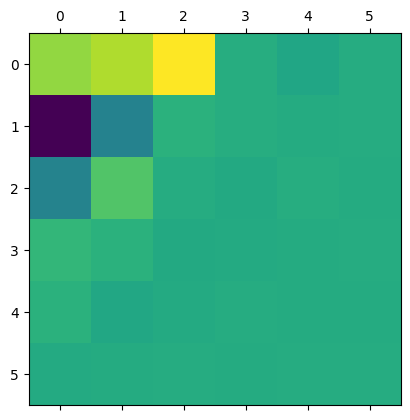

In [341]:
plt.matshow(cuml_c.get().reshape((n_c,n_c)))

In [559]:
Gb = xp.exp(1j * (Tau - abbD))  # calculate the terms needed for summation
Phib = np.pi * (xp.real(Gb) < 0) * circD
if xp == cp:
    imgb = Phib.get()
else:
    imgb = Phib

for i in range(n_bias):
    hex_bitsb[i] = np.packbits(imgb.astype('int'), bitorder='little')
timestamp = time.strftime("%d%m%y_%H%M%S", time.localtime())
har.updateBp(hex_bitsb, f'iter{nits}_{timestamp}', 'nh')

sending frame number 11
bitplane sent in 1.2333569526672363
sending frame number 12
bitplane sent in 1.2789015769958496
sending frame number 13
bitplane sent in 1.2759063243865967
New rep file created
C:\Users\ML2618\Desktop\SLMtests

REP file: C:\Users\ML2618\Desktop\SLMtests\iter375_250723_162157.rep
Seq path: C:\Users\ML2618\Desktop\SLMtests
Img path: C:\Users\ML2618\Desktop\SLMtests

Seq file: 48163 10ms 1-bit Balanced.seq11
Img file: hol.png
Img file: hol.png
Img file: hol.png

Target platform: R11 (obtained from Repertoire)
Target display: 2Kx2K (obtained from Repertoire)
Target format version: FV4 (obtained from Repertoire)
Unique identifier (template): "V1.0 ${date(\"yyyy-MMM-dd HH:mm:ss\")}"
Unique identifier (evaluated): V1.0 2023-Jul-25 16:22:02

Creating "iter375_250723_162157.repz11"

repz11 file created
Port closed successfully
New repertoire sent without images.
Open Dev port successfully
Display temperature: 10224
Repertoire updated in 17.190260887145996s


65535


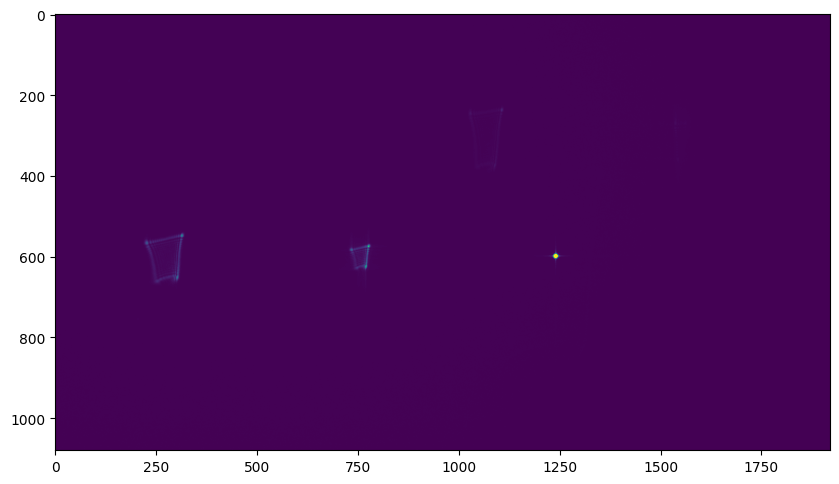

In [560]:
cam.set_trigger_mode('int')
cam.set_exposure(0.002)
corr_PSF = cam.snap()
plt.figure(figsize=(10, 10))
plt.imshow(corr_PSF)
print(corr_PSF.max())

## Camera functions

Live camera viewing.

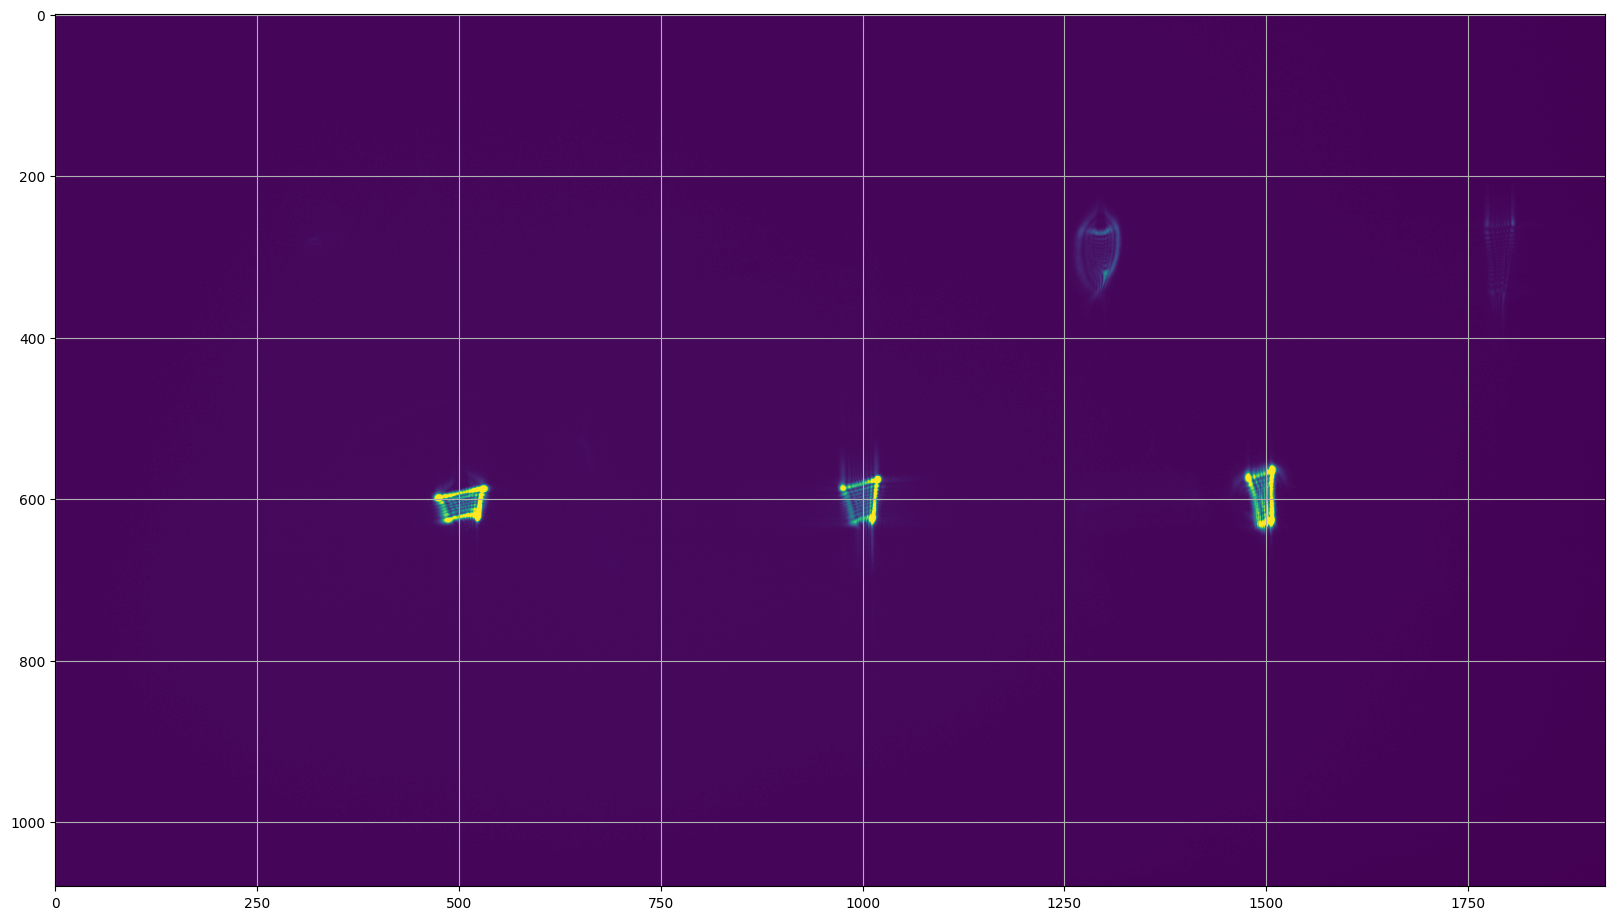

In [114]:
cam.set_exposure(0.010)
cam.set_trigger_mode('int')
# cam.set_roi(hstart=1000-N/2, hend=1000+N/2, vstart=600-N/2, vend=600+N/2, hbin=1, vbin=1)
cam.set_roi(hstart=0, hend=None, vstart=0, vend=None, hbin=1, vbin=1)
# # cam.set_roi(hstart=650, hend=906, vstart=127, vend=383, hbin=1, vbin=1)
# cam.set_roi(hstart=522, hend=1034, vstart=0, vend=512, hbin=1, vbin=1)
fig, ax = plt.subplots(figsize=(20,20))
tc0 = time.time()
while time.time() - tc0 < 50:
    frame = cam.snap()
    ax.clear()
    ax.imshow(frame)
    ax.grid(visible=True)
    display.clear_output(wait=True)
    display.display(ax.get_figure())
    plt.pause(0.1)

Full screen viewing

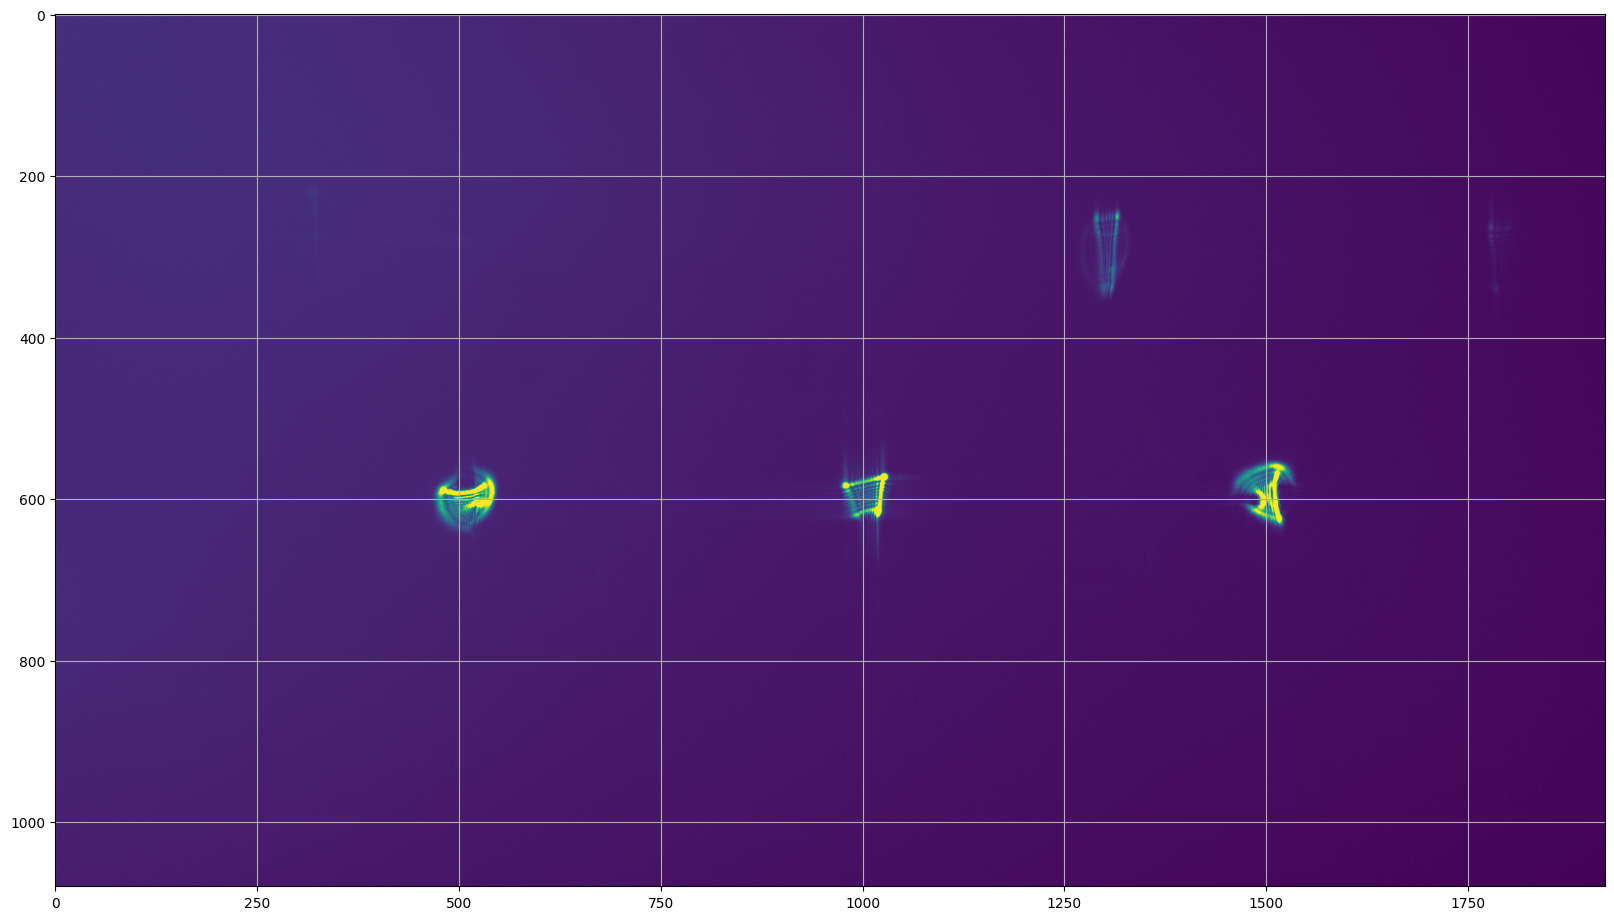

In [92]:
cam.set_trigger_mode('int')
cam.set_exposure(0.01)
cam.set_roi(hstart=0, hend=None, vstart=0, vend=None, hbin=1, vbin=1)
img1 = cam.snap()
plt.figure(figsize=(20,20))
plt.grid(visible=True)
plt.imshow(img1)

Checking the ROI.

65535


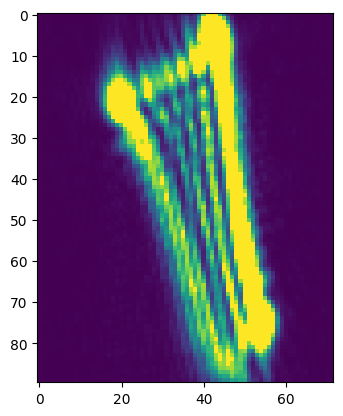

In [154]:
cam.set_exposure(0.010)
cam.set_trigger_mode('int')
cam.set_roi(hstart=1180, hend=1250, vstart=370, vend=460, hbin=1, vbin=1)
ri = cam.snap()
plt.imshow(ri)
print(ri.max())

Checking background subtraction

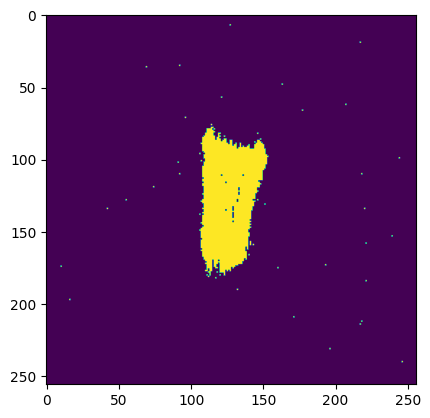

In [443]:
bg = np.percentile(ri.flatten(), 95)
plt.imshow(ri > bg)

Record multiple frames of PSF to check the stability

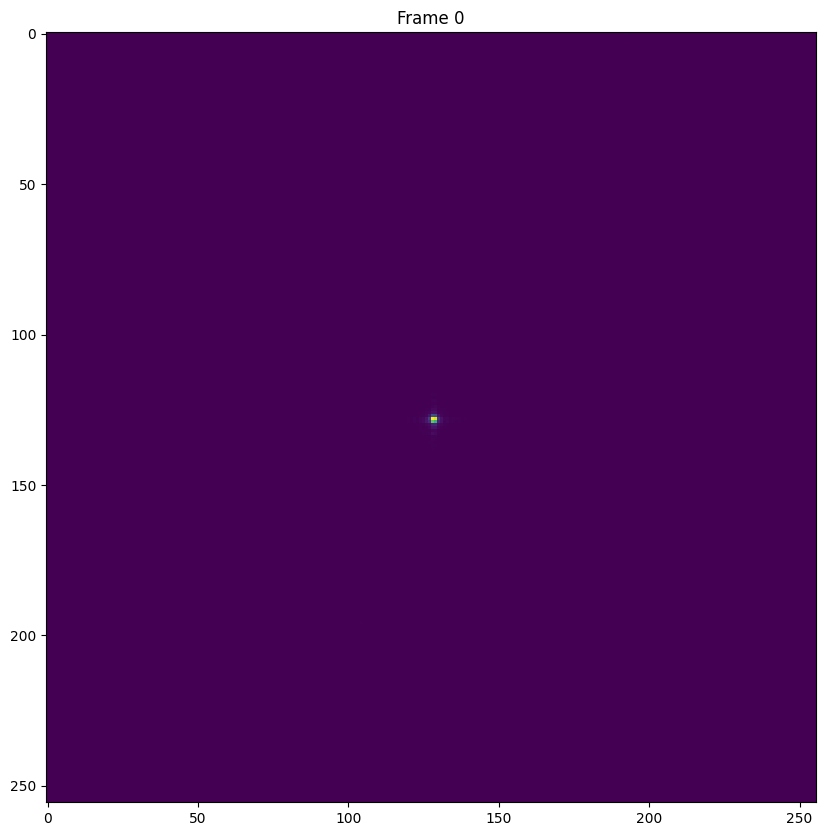

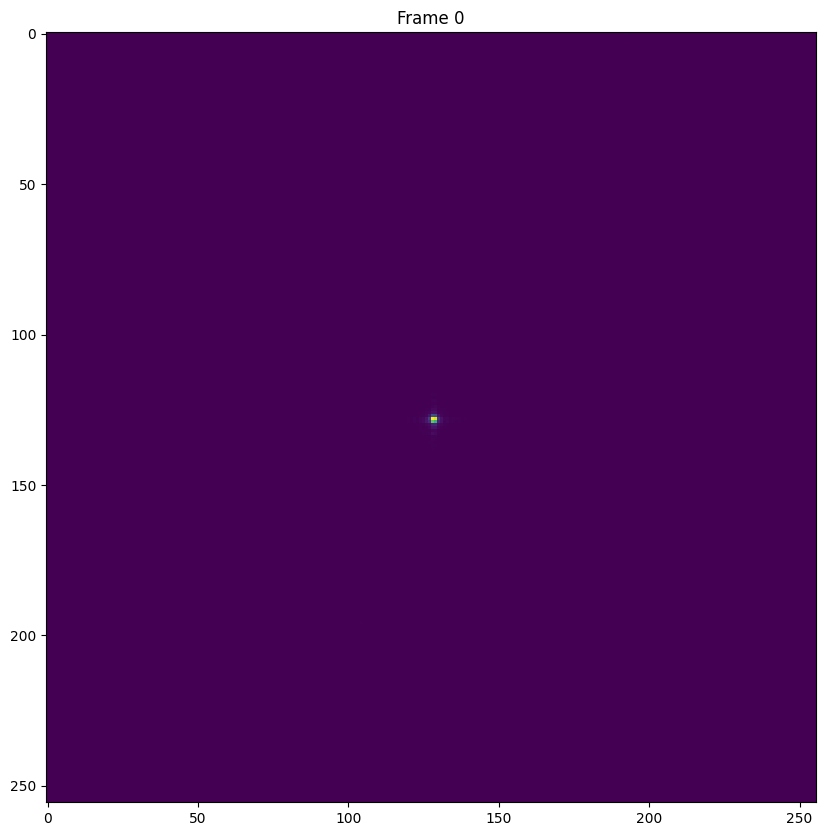

In [43]:
# slm.setRO(2)
# cam.set_exposure(0.004)
tt0 = time.time()
frames = cam.grab(nframes=100, frame_timeout=5.0, missing_frame='skip', return_info=False, buff_size=None)
print(time.time() - tt0)

f = plt.figure(figsize=(10, 10))
ax = plt.axes()

def show_frames(img, title=None):
    ax.clear()
    s = ax.imshow(img)
    display.clear_output(wait=True)
    ax.set_title(title)
    display.display(ax.get_figure())

def img_func(i):
    show_frames(frames[i], f'Frame {i}')
    return (frames[i])
    
ani = animation.FuncAnimation(fig=f, func=img_func, frames=len(frames))
writergif = animation.PillowWriter(fps=5)
ani.save(f'{time.strftime("%d%m%y_%H%M%S", time.localtime())}.gif', writer=writergif, dpi=100)